<a href="https://colab.research.google.com/github/IsmailOtukoya/CreditCard-Fraud-Detection-/blob/main/CreditCard_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

index - Unique Identifier for each row

trans_date_trans_time - Transaction DateTime

cc_num - Credit Card Number of Customer

merchant - Merchant Name
category - Category of Merchant

amt - Amount of Transaction

first - First Name of Credit Card Holder

last - Last Name of Credit Card Holder

gender - Gender of Credit Card Holder

street - Street Address of Credit Card Holder

city - City of Credit Card Holder

state - State of Credit Card Holder

zip - Zip of Credit Card Holder

lat - Latitude Location of Credit Card Holder

long - Longitude Location of Credit Card Holder

city_pop - Credit Card Holder's City Population

job - Job of Credit Card Holder

dob - Date of Birth of Credit Card Holder

trans_num - Transaction Number

unix_time - UNIX Time of transaction

merch_lat - Latitude Location of Merchant

merch_long - Longitude Location of Merchant

is_fraud - Fraud Flag <--- Target Class


# **Data Exploration**

Dataset Information:

The dataset contains 35,041 entries and 23 columns.
Column types include int64, float64, and object (likely representing strings).
The "is_fraud" column has one missing value.
First Few Rows:

The first few rows of the dataset provide a glimpse of the data structure and content.
Summary Statistics:

Summary statistics for numerical columns (count, mean, std, min, 25%, 50%, 75%, max).
The mean for the "is_fraud" column suggests a low overall incidence of fraud (mean = 0.010074).
Unique Values in 'is_fraud':

The target variable "is_fraud" is binary, with 0.0 indicating non-fraudulent transactions and 1.0 indicating fraudulent transactions.
Most entries (34,687) are non-fraudulent, while there are 353 instances of fraud.
Missing Values:

There is one missing value in the "is_fraud" column, which needs to be addressed before training the model.

---



---



In [ ]:
import pandas as pd

# Load the dataset
file_path = r'/content/fraudTrain.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())

# Unique values in the target variable "is_fraud"
print("\nUnique values in 'is_fraud':")
print(df['is_fraud'].value_counts())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long

In [ ]:
not_fraud_count, fraud_count = np.bincount(df["is_fraud"])

total_count = not_fraud_count + fraud_count
print(
    (
        f"Data:\n"
        f"    Total: {total_count}\n"
        f"    Fraud: {fraud_count} ({100 * fraud_count / total_count:.2f}% of total)\n"
    )
)

Data:
    Total: 1296675
    Fraud: 7506 (0.58% of total)



In [ ]:
df = pd.concat(
    [
        df[df["is_fraud"] == 0].sample(1000, random_state=0),
        df[df["is_fraud"] == 1].sample(1000, random_state=0),
    ]
)

fig = px.histogram(
    df,
    title="Transaction count for different amounts",
    x="amt",
    color="is_fraud",
    marginal="box",
)
fig.update_traces(opacity=0.75)
fig.update_layout(barmode="overlay")
fig.show()

In [ ]:
import plotly.express as px

# Create a scatter map for credit card holder locations
fig = px.scatter_mapbox(
    df,
    lat='lat',
    lon='long',
    color='is_fraud',
    size='amt',
    hover_data=['first', 'last', 'amt', 'trans_num'],
    title='Credit Card Holder Locations',
    mapbox_style='open-street-map',
    center=dict(lat=df['lat'].mean(), lon=df['long'].mean()),
    zoom=3
)

# Add markers for merchant locations
#fig.add_scattermapbox(
    #lat=df['merch_lat'],
    #lon=df['merch_long'],
    #mode='markers',
    ##marker=dict(size=10, color='red'),
    #name='Merchant Locations'

# Show the interactive map
fig.show()


In [ ]:
from datetime import timedelta

# Assuming 'trans_date_trans_time' is in datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df = df.drop('day_of_week', axis=1)
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] < 6)).astype(int)
df = df.drop('hour_of_day', axis=1)


In [117]:
# Sort DataFrame by 'trans_date_trans_time'
df = df.sort_values(by='trans_date_trans_time')

df["customer_num_transactions_1_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["customer_num_transactions_7_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["customer_num_transactions_30_day"] = df.groupby(
    "cc_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count()
)[
    "amt"
]

df["customer_avg_amount_1_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean()
)["amt"]
df["customer_avg_amount_7_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean()
)["amt"]
df["customer_avg_amount_30_day"] = df.groupby("cc_num").apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean()
)["amt"]


<ipython-input-117-9f6f0decd593>:6: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-117-9f6f0decd593>:13: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-117-9f6f0decd593>:20: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the 

In [118]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_long,is_fraud,is_weekend,is_night,customer_num_transactions_1_day,customer_num_transactions_7_day,customer_num_transactions_30_day,customer_avg_amount_1_day,customer_avg_amount_7_day,customer_avg_amount_30_day
1152,1152,2019-01-01 13:53:24,3527536963490470,fraud_Dooley Inc,shopping_pos,8.82,Teresa,Stein,F,2838 White Fields Apt. 473,...,-81.540547,0,0,0,1.0,1.0,1.0,8.82,8.82,8.82
3683,3683,2019-01-03 03:38:06,213136802746375,fraud_Mohr-Bayer,shopping_net,2.96,Christine,Davis,F,736 Moss Motorway Suite 549,...,-111.611563,0,0,1,1.0,1.0,1.0,2.96,2.96,2.96
4260,4260,2019-01-03 15:46:04,4599285557366057,fraud_Stiedemann Ltd,food_dining,7.44,Mary,Williams,F,00315 Ashley Valleys,...,-96.973873,0,0,0,1.0,1.0,1.0,7.44,7.44,7.44
4693,4693,2019-01-03 22:58:44,4922710831011201,fraud_Mosciski Group,travel,4.50,Heather,Chase,F,6888 Hicks Stream Suite 954,...,-78.859114,1,0,1,1.0,1.0,1.0,4.50,4.50,4.50
5536,5536,2019-01-04 14:51:45,4450831335606294,"fraud_Romaguera, Wehner and Tromp",kids_pets,87.21,Donna,Davis,F,6760 Donovan Lakes,...,-95.913434,0,0,0,1.0,1.0,1.0,87.21,87.21,87.21


In [119]:
from datetime import datetime

import pandas as pd
from datetime import timedelta


df['dob'] = pd.to_datetime(df['dob'])

# Calculate transaction hour and day
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day

# Calculate age of the customer based on today's date
current_date = datetime(2023, 12, 19)  # Today's date
df['age'] = (current_date - df['dob']).astype('<m8[Y]')

# Drop the original 'trans_date_trans_time' and 'dob' columns
#df = df.drop(['trans_date_trans_time', 'dob'], axis=1)

# Display the updated DataFrame
print(df.head())


      Unnamed: 0 trans_date_trans_time            cc_num  \
1152        1152   2019-01-01 13:53:24  3527536963490470   
3683        3683   2019-01-03 03:38:06   213136802746375   
4260        4260   2019-01-03 15:46:04  4599285557366057   
4693        4693   2019-01-03 22:58:44  4922710831011201   
5536        5536   2019-01-04 14:51:45  4450831335606294   

                               merchant      category    amt      first  \
1152                   fraud_Dooley Inc  shopping_pos   8.82     Teresa   
3683                   fraud_Mohr-Bayer  shopping_net   2.96  Christine   
4260               fraud_Stiedemann Ltd   food_dining   7.44       Mary   
4693               fraud_Mosciski Group        travel   4.50    Heather   
5536  fraud_Romaguera, Wehner and Tromp     kids_pets  87.21      Donna   

          last gender                       street  ... is_night  \
1152     Stein      F   2838 White Fields Apt. 473  ...        0   
3683     Davis      F  736 Moss Motorway Suite 549  

In [ ]:
df.head()

,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day,age
0,0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,0,1,35.0
1,1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,0,1,45.0
2,2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,0,1,61.0
3,3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,0,1,56.0
4,4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,0,1,37.0


Fraud risk
The fraud risk is the proportion of transactions for this terminal that were fraudulent or not—over the past 1, 7, or 30 days.

However, we assume that we can only know for sure whether a transaction was fraudulent or not after some delay (7 days in this case) after some manual review. Therefore, risk calculations are delayed by 7 days. This means the risk calculation for a transaction on day N is actually for day N-7.

The function get_count_risk_rolling_window below shows how this is calculated.

In [121]:
DAY_DELAY = 7

def get_count_risk_rolling_window(
    terminal_transactions, window_size, delay_period=DAY_DELAY
):
    frauds_in_delay = terminal_transactions.rolling(
        str(delay_period) + "d", on="trans_date_trans_time"
    )["is_fraud"].sum()
    transactions_in_delay = terminal_transactions.rolling(
        str(delay_period) + "d", on="trans_date_trans_time"
    )["is_fraud"].count()

    frauds_until_window = terminal_transactions.rolling(
        str(delay_period + window_size) + "d", on="trans_date_trans_time"
    )["is_fraud"].sum()
    transactions_until_window = terminal_transactions.rolling(
        str(delay_period + window_size) + "d", on="trans_date_trans_time"
    )["is_fraud"].count()

    frauds_in_window = frauds_until_window - frauds_in_delay
    transactions_in_window = transactions_until_window - transactions_in_delay

    terminal_transactions["fraud_risk"] = (
        frauds_in_window / transactions_in_window
    ).fillna(0)

    return terminal_transactions


df["terminal_num_transactions_1_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["terminal_num_transactions_7_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count()
)[
    "amt"
]
df["terminal_num_transactions_30_day"] = df.groupby(
    "trans_num"
).apply(
    lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count()
)[
    "amt"
]

df["terminal_fraud_risk_1_day"] = df.groupby("trans_num").apply(
    lambda x: get_count_risk_rolling_window(x, 1, 7)
)["fraud_risk"]
df["terminal_fraud_risk_7_day"] = df.groupby("trans_num").apply(
    lambda x: get_count_risk_rolling_window(x, 7, 7)
)["fraud_risk"]
df["terminal_fraud_risk_30_day"] = df.groupby("trans_num").apply(
    lambda x: get_count_risk_rolling_window(x, 30, 7)
)["fraud_risk"]

<ipython-input-121-2c7215a09b13>:32: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-121-2c7215a09b13>:39: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-121-2c7215a09b13>:46: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the

In [122]:
pd.concat(
    # show some fraudulent and non-fraudulent transactions
    [
        df[df["is_fraud"] == 1].sample(5, random_state=0),
        df[df["is_fraud"] == 0].sample(5, random_state=0),
    ]
).sample(10, random_state=0)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,customer_avg_amount_30_day,trans_hour,trans_day,age,terminal_num_transactions_1_day,terminal_num_transactions_7_day,terminal_num_transactions_30_day,terminal_fraud_risk_1_day,terminal_fraud_risk_7_day,terminal_fraud_risk_30_day
292377,292377,2019-05-24 03:16:01,213193596103206,fraud_Cummings LLC,gas_transport,10.15,James,Hunt,M,7369 Gabriel Tunnel,...,10.150,3,24,29.0,1.0,1.0,1.0,0.0,0.0,0.0
744057,744057,2019-11-14 15:00:33,676118385837,fraud_Douglas-White,entertainment,13.62,Katelyn,Wise,F,674 Maureen Summit Apt. 276,...,13.620,15,14,86.0,1.0,1.0,1.0,0.0,0.0,0.0
878354,878354,2019-12-22 00:16:57,4742883543039288059,"fraud_Heathcote, Yost and Kertzmann",shopping_net,1012.73,Cassandra,Sanders,F,78117 George Mountains,...,1012.730,0,22,32.0,1.0,1.0,1.0,0.0,0.0,0.0
870624,870624,2019-12-20 11:07:12,4740713119940984,fraud_Haag-Blanda,food_dining,27.47,Heather,Hines,F,13776 Hicks Plains,...,27.470,11,20,61.0,1.0,1.0,1.0,0.0,0.0,0.0
1103783,1103783,2020-04-04 15:02:16,3559160581764413,fraud_McDermott-Weimann,grocery_pos,302.90,Allen,Bell,M,70147 Amanda Fields,...,529.140,15,4,49.0,1.0,1.0,1.0,0.0,0.0,0.0
1119874,1119874,2020-04-11 14:44:11,4862293128558,fraud_Osinski Inc,personal_care,22.68,Elizabeth,Payne,F,897 Daugherty Mission,...,22.680,14,11,67.0,1.0,1.0,1.0,0.0,0.0,0.0
417132,417132,2019-07-07 10:41:25,375767678113375,"fraud_Altenwerth, Cartwright and Koss",shopping_net,7.76,Christopher,Patterson,M,16744 Campbell Wall Apt. 372,...,7.760,10,7,61.0,1.0,1.0,1.0,0.0,0.0,0.0
692117,692117,2019-10-21 22:57:37,3546897637165774,"fraud_Schmeler, Bashirian and Price",shopping_net,1086.91,Kayla,Obrien,F,7921 Robert Port Suite 343,...,1092.355,22,21,67.0,1.0,1.0,1.0,0.0,0.0,0.0
1290670,1290670,2020-06-19 01:41:20,4986925034905735,fraud_Vandervort-Funk,grocery_pos,291.92,Erika,Gonzalez,F,907 Courtney Via Apt. 896,...,291.920,1,19,64.0,1.0,1.0,1.0,0.0,0.0,0.0
1284813,1284813,2020-06-16 13:54:13,371226440126102,fraud_Schoen-Quigley,kids_pets,15.91,Stacy,Lambert,F,85430 Julie Trafficway Suite 792,...,15.910,13,16,48.0,1.0,1.0,1.0,0.0,0.0,0.0


In [123]:
# Display the data types of each column in the DataFrame
print(df.dtypes)


Unnamed: 0                                   int64
trans_date_trans_time               datetime64[ns]
cc_num                                       int64
merchant                                    object
category                                    object
amt                                        float64
first                                       object
last                                        object
gender                                      object
street                                      object
city                                        object
state                                       object
zip                                          int64
lat                                        float64
long                                       float64
city_pop                                     int64
job                                         object
dob                                 datetime64[ns]
trans_num                                   object
unix_time                      

In [ ]:
import plotly.express as px

# Create a bar chart for the gender column
fig = px.bar(
    df,
    x='gender',
    title='Gender Distribution',
    labels={'gender': 'Gender', 'count': 'Count'},
    color_discrete_sequence=['blue', 'pink']  # Colors for male and female
)

# Show the interactive bar chart
fig.show()


In [ ]:
!pip install plotly
#pip install --upgrade plotly


In [ ]:
import plotly.express as px

# Create a scatter map for credit card holder locations
fig = px.scatter_mapbox(
    df,
    lat='lat',
    lon='long',
    color='is_fraud',
    size='amt',
    hover_data=['first', 'last', 'amt', 'trans_num'],
    title='Credit Card Holder Locations',
    mapbox_style='open-street-map',
    center=dict(lat=df['lat'].mean(), lon=df['long'].mean()),
    zoom=3
)

# Add markers for merchant locations
#fig.add_scattermapbox(
    #lat=df['merch_lat'],
    #lon=df['merch_long'],
    #mode='markers',
    ##marker=dict(size=10, color='red'),
    #name='Merchant Locations'

# Show the interactive map
fig.show()


In [ ]:
df.head()

In [ ]:
pip install -U imbalanced-learn


In [ ]:
pip install category_encoders


In [ ]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE

# Assuming 'gender' column in your DataFrame
df['gender_encoded'] = df['gender'].map({'M': 0, 'F': 1})
# Drop the original 'gender' column if needed
df = df.drop('gender', axis=1)
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num']
df = df.drop(columns=columns_to_drop, axis=1)

# Target encoding for categorical variables
encoder = TargetEncoder()
categorical_columns = ['merchant', 'category', 'job', 'state', 'city']
df[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['is_fraud'])








In [ ]:
# Handle data imbalance using SMOTE
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Now, X_resampled and y_resampled are the balanced training sets



import matplotlib.pyplot as plt
import seaborn as sns

# Plot the class distribution before and after SMOTE
#plt.figure(figsize=(12, 6))

# Plot original class distribution
#plt.subplot(1, 2, 1)
#sns.countplot(x='is_fraud', data=df)
#plt.title('Class Distribution (Original)')

# Plot class distribution after SMOTE
#plt.subplot(1, 2, 2)
#sns.countplot(x=y_resampled)
#plt.title('Class Distribution (After SMOTE)')

#plt.show()

#print("Class distribution before SMOTE:")
#print(df['is_fraud'].value_counts())

#print("\nClass distribution after SMOTE:")
#print(pd.Series(y_resampled).value_counts())

In [ ]:
print(df['job'].unique())


[0.38974718 0.5802836  0.16969801 0.01256813 0.51114583 0.31346474
 0.36342939 0.50188447 0.46948892 0.39035992 0.24234126 0.52350604
 0.47145999 0.43074724 0.45428892 0.41673305 0.52476205 0.42268317
 0.34025179 0.42152279 0.30512896 0.29317501 0.47977905 0.37015558
 0.57137014 0.41086082 0.39558773 0.28998688 0.50486466 0.49868497
 0.46560913 0.48437387 0.31868293 0.21176938 0.29138019 0.20643155
 0.52993894 0.34598871 0.26766102 0.58022703 0.37510047 0.51247843
 0.40482221 0.38910767 0.28636895 0.24630502 0.39731765 0.47010938
 0.49196254 0.37502689 0.48555594 0.22930062 0.34666429 0.22619568
 0.57742332 0.4671524  0.3361657  0.45327409 0.03907054 0.3754274
 0.39750356 0.48086993 0.35470631 0.37399015 0.35141672 0.42509327
 0.20770167 0.37807735 0.25224163 0.40579892 0.22487161 0.38586218
 0.2375492  0.37163215 0.39158126 0.38744579 0.47481885 0.56726125
 0.25669768 0.43377747 0.53416528 0.36106407 0.20367338 0.23422554
 0.23575083 0.36499948 0.1285697  0.4369994  0.49431596 0.41249

In [ ]:
# Display the data types of each column in the DataFrame
print(df.dtypes)

merchant          float64
category          float64
amt               float64
city              float64
state             float64
zip                 int64
lat               float64
long              float64
city_pop            int64
job               float64
unix_time           int64
merch_lat         float64
merch_long        float64
is_fraud            int64
trans_hour          int64
trans_day           int64
age               float64
gender_encoded      int64
dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight



# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate on the test set
y_pred = model.predict(X_test_scaled)

# Convert y_test to binary labels
y_test_binary = (y_test > 0.5).astype(int)

# Convert y_pred to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Run classification_report
print(classification_report(y_test_binary, y_pred_binary))



Epoch 1/10
351/351 [==============================] - 2s 3ms/step - loss: 0.4052 - accuracy: 0.8153 - val_loss: 0.3050 - val_accuracy: 0.8704
Epoch 2/10
351/351 [==============================] - 1s 2ms/step - loss: 0.2812 - accuracy: 0.8876 - val_loss: 0.2553 - val_accuracy: 0.8961
Epoch 3/10
351/351 [==============================] - 1s 2ms/step - loss: 0.2449 - accuracy: 0.8981 - val_loss: 0.2329 - val_accuracy: 0.9025
Epoch 4/10
351/351 [==============================] - 1s 2ms/step - loss: 0.2269 - accuracy: 0.9066 - val_loss: 0.2263 - val_accuracy: 0.9036
Epoch 5/10
351/351 [==============================] - 1s 3ms/step - loss: 0.2167 - accuracy: 0.9089 - val_loss: 0.2167 - val_accuracy: 0.9132
Epoch 6/10
351/351 [==============================] - 1s 4ms/step - loss: 0.2084 - accuracy: 0.9139 - val_loss: 0.2144 - val_accuracy: 0.9100
Epoch 7/10
351/351 [==============================] - 1s 4ms/step - loss: 0.2036 - accuracy: 0.9159 - val_loss: 0.2130 - val_accuracy: 0.9154
Epoch 

In [ ]:
import os

# Defining the directory path
directory_path = '/content/drive/MyDrive/'

# Create the directory because  it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the model to Google Drive in the Keras format
model.save(os.path.join(directory_path, 'fraud_detection_model1.keras'))


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the new data
file_path = r'/content/fraudTest.csv'
df_new = pd.read_csv(file_path)

df_new.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
print(df_new.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [ ]:
# Check unique values in the target variable
unique_values = df_new['is_fraud'].unique()
print("Unique values in the target variable:", unique_values)


Unique values in the target variable: [0 1]


In [ ]:
df_new = df_new.dropna(subset=['is_fraud'])

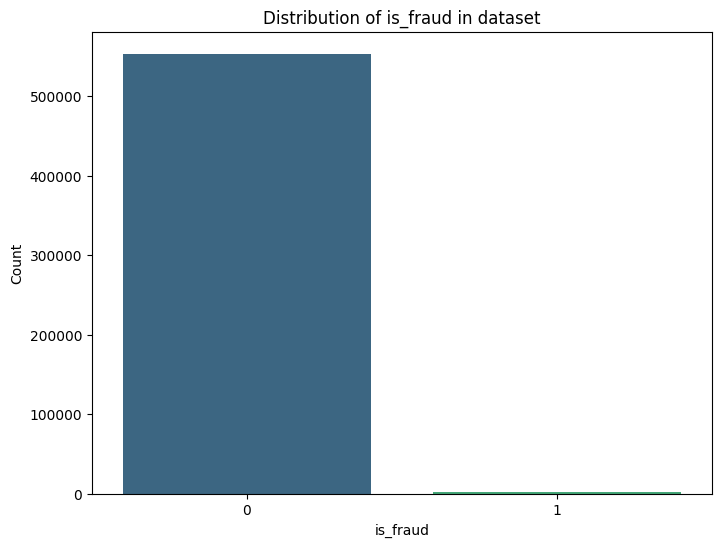

0    553574
1      2145
Name: is_fraud, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in 'is_fraud'
fraud_counts = df_new['is_fraud'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.title('Distribution of is_fraud in dataset')

# Show the plot
plt.show()

# Count the occurrences of each unique value in 'is_fraud'
fraud_counts = df_new['is_fraud'].value_counts()

# Display the counts
print(fraud_counts)


In [ ]:
# Assuming df is your original DataFrame
df_majority = df_new[df_new['is_fraud'] == 0].sample(n=3000, random_state=42)
df_minority = df_new[df_new['is_fraud'] == 1]

# Concatenate the balanced datasets
df_new = pd.concat([df_majority, df_minority], ignore_index=True)


In [ ]:
# Assuming df_new is your DataFrame
num_rows = df_new.shape[0]

print(f"The number of rows in the dataset is: {num_rows}")


The number of rows in the dataset is: 5145


In [ ]:
# Check unique values in the target variable
unique_values = df_new['is_fraud'].unique()
print("Unique values in the target variable:", unique_values)


Unique values in the target variable: [0 1]


In [ ]:
df_new.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,547885,2020-12-29 19:17:03,371226440126102,"fraud_Medhurst, Cartwright and Ebert",personal_care,60.51,Stacy,Lambert,F,85430 Julie Trafficway Suite 792,...,38.9311,-89.2463,1810,Race relations officer,1974-12-24,048c8b965dfcbdd9b023f6a5160beb0d,1388344623,39.205918,-88.295627,0
1,528140,2020-12-26 03:46:04,6596735789587928,fraud_Pouros-Haag,shopping_pos,2.36,Spencer,Williams,M,1145 Tony Drive Suite 080,...,44.9595,-93.8482,5619,Licensed conveyancer,1959-01-15,828b54bd4d205f1114bce6fa8bc8f433,1388029564,44.826412,-93.239743,0
2,129300,2020-08-04 22:27:26,30551643947183,"fraud_Mante, Luettgen and Hackett",health_fitness,5.55,Morgan,Smith,F,1441 Bradley Place,...,35.1836,-81.4552,5621,Toxicologist,1973-11-14,383ac06cc8c02ef1e2c2bee329a30f77,1375655246,34.787130,-81.789226,0
3,354681,2020-11-05 11:29:52,6011388901471808,"fraud_Goldner, Kovacek and Abbott",grocery_pos,115.80,Jacqueline,Marsh,F,950 Sheryl Spurs,...,40.1151,-79.8627,427,Mining engineer,1951-02-05,506ea157ec09c9f04eb3ea8bed59d33a,1383650992,39.342100,-80.375392,0
4,182576,2020-08-24 12:08:18,6011348830550197,"fraud_Turner, Ziemann and Lehner",food_dining,8.30,Samuel,Johnston,M,16285 Jessica Lights,...,33.4629,-86.7904,493806,Musician,1980-07-12,5646a4a1c03bf24f0dcc364e0116f7cd,1377346098,33.627330,-87.257660,0


In [ ]:
from datetime import datetime

# Convert 'trans_date_trans_time' and 'dob' columns to datetime
df_new['trans_date_trans_time'] = pd.to_datetime(df_new['trans_date_trans_time'])
df_new['dob'] = pd.to_datetime(df_new['dob'])

# Calculate transaction hour and day
df_new['trans_hour'] = df_new['trans_date_trans_time'].dt.hour
df_new['trans_day'] = df_new['trans_date_trans_time'].dt.day

# Calculate age of the customer based on today's date
current_date = datetime(2023, 12, 19)  # Today's date
df_new['age'] = (current_date - df_new['dob']).astype('<m8[Y]')

# Drop the original 'trans_date_trans_time' and 'dob' columns
df_new = df_new.drop(['trans_date_trans_time', 'dob'], axis=1)

# Display the updated DataFrame
print(df_new.head())


   merchant  category    amt      city     state    zip      lat      long  \
0  0.371632  0.378909  86.19  0.256698  0.411097  90403  34.0287 -118.4924   
1  0.325098  0.256044  85.81  0.488738  0.389002  63867  36.7154  -89.6287   
2  0.574473  0.640809  99.30  0.286497  0.430451  15449  39.9636  -79.7853   
3  0.271028  0.168942  42.09  0.115313  0.244278  59448  48.2777 -112.8456   
4  0.616490  0.680302   4.24  0.436218  0.505415  37663  36.4715  -82.4834   

   city_pop       job   unix_time  merch_lat  merch_long  is_fraud  \
0     92043  0.389747  1354877706  33.287851 -118.740970         0   
1      1019  0.580284  1364994606  36.539950  -89.857416         0   
2       184  0.169698  1354604824  39.582872  -78.838550         0   
3       743  0.012568  1341081788  48.310513 -112.837535         0   
4     87124  0.511146  1334519869  37.329094  -82.070746         0   

   trans_hour  trans_day   age  gender_encoded  
0          10          7  62.0               1  
1          1

In [ ]:
# Define the columns for each processing step
categorical_columns = ['merchant', 'category', 'job', 'state', 'city']
numeric_columns = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'trans_hour', 'trans_day', 'age']


#Assuming 'gender' column in your DataFrame
#df_new['gender_encoded'] = df_new['gender'].map({'M': 0, 'F': 1})
# Drop the original 'gender' column if needed
#df_new = df_new.drop('gender', axis=1)

# Step 1: Target Encoding for Categorical Columns
encoder = TargetEncoder()
df_new[categorical_columns] = encoder.fit_transform(df_new[categorical_columns], df_new['is_fraud'])

# Step 2: Imputation and Scaling for Numeric Columns
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

df_new[numeric_columns] = scaler.fit_transform(imputer.fit_transform(df_new[numeric_columns]))

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num']
df_new = df_new.drop(columns=columns_to_drop, axis=1)

df_new.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day,age
0,0.428696,0.263158,-0.538416,F,0.340855,0.429379,62262,0.029751,0.077331,-0.292956,0.296402,1.649257,0.083592,0.146074,0,0.686186,1.462128,-0.140503
1,0.454066,0.433809,-0.696090,M,0.533814,0.521428,55388,1.220890,-0.254055,-0.277452,0.714042,1.585319,1.189087,-0.209823,0,-1.281311,1.127178,0.777088
2,0.349340,0.203922,-0.687440,F,0.421042,0.345866,28073,-0.710709,0.638372,-0.277444,0.337633,-0.925898,-0.785538,0.614430,0,1.055092,-1.329125,-0.025804
3,0.482766,0.645806,-0.388498,F,0.340855,0.367742,15432,0.263695,0.753049,-0.298586,0.249599,0.696741,0.110378,0.716203,0,-0.297562,-1.217475,1.235883
4,0.339328,0.200000,-0.679984,M,0.647824,0.391304,35229,-1.050699,0.254181,1.709734,0.296402,-0.582760,-1.013659,0.220791,0,-0.174594,0.903878,-0.427251


In [ ]:
#Assuming 'gender' column in your DataFrame
df_new['gender_encoded'] = df_new['gender'].map({'M': 0, 'F': 1})
# Drop the original 'gender' column if needed
df_new = df_new.drop('gender', axis=1)

In [ ]:
# Drop the original 'gender' column if needed
#df_new = df_new.drop('gender', axis=1)

#df_new.head()

In [ ]:
# Handle data imbalance using SMOTE
X = df_new.drop('is_fraud', axis=1)
y = df_new['is_fraud']







In [ ]:
# Check unique values in the target variable
unique_values = df_new['is_fraud'].unique()
print("Unique values in the target variable:", unique_values)


Unique values in the target variable: [0 1]


In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the trained model
model_path = '/content/drive/MyDrive/fraud_detection_model1.keras'
loaded_model = load_model(model_path)

# Assuming X_resampled is your preprocessed and balanced new data
# Make predictions on the new data
predictions = loaded_model.predict(X)

# Assuming predictions are probabilities, convert them to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Evaluate the performance of the model
accuracy = accuracy_score(y, binary_predictions)
classification_report_result = classification_report(y, binary_predictions)
conf_matrix = confusion_matrix(y, binary_predictions)

# Print the evaluation results
print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(classification_report_result)
print('\nConfusion Matrix:')
print(conf_matrix)


161/161 [==============================] - 0s 2ms/step
Accuracy: 0.41690962099125367

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3000
           1       0.42      1.00      0.59      2145

    accuracy                           0.42      5145
   macro avg       0.21      0.50      0.29      5145
weighted avg       0.17      0.42      0.25      5145


Confusion Matrix:
[[   0 3000]
 [   0 2145]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
df_new.info()